In [39]:
import yfinance as yf
import pandas as pd

# Microsoft Stock Data  
ticker = "MSFT"

data = yf.download(ticker, start="1986-03-13", end="2025-11-06")

# Drop the multi-level column if present
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)

# save to csv
data.to_csv('MSFT_Historic_Data.csv')

print("Data downloaded and saved as MSFT_Historic_Data.csv")
print(data.head())

C:\Users\USER\AppData\Local\Temp\ipykernel_13040\4186675846.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1986-03-13", end="2025-11-06")
[*********************100%***********************]  1 of 1 completed


Data downloaded and saved as MSFT_Historic_Data.csv
Price          Close      High       Low      Open      Volume
Date                                                          
1986-03-13  0.059500  0.062157  0.054188  0.054188  1031788800
1986-03-14  0.061625  0.062688  0.059500  0.059500   308160000
1986-03-17  0.062688  0.063219  0.061625  0.061625   133171200
1986-03-18  0.061093  0.063219  0.060562  0.062688    67766400
1986-03-19  0.060031  0.061625  0.059500  0.061093    47894400


In [40]:
df = pd.read_csv('MSFT_Historic_Data.csv')
print("\nRaw CSV Data:")
print(df.head())


Raw CSV Data:
         Date     Close      High       Low      Open      Volume
0  1986-03-13  0.059500  0.062157  0.054188  0.054188  1031788800
1  1986-03-14  0.061625  0.062688  0.059500  0.059500   308160000
2  1986-03-17  0.062688  0.063219  0.061625  0.061625   133171200
3  1986-03-18  0.061093  0.063219  0.060562  0.062688    67766400
4  1986-03-19  0.060031  0.061625  0.059500  0.061093    47894400


In [41]:
df = df[['Date', 'Close']].copy()
print("\nSelected Columns:")
print(df.head())


Selected Columns:
         Date     Close
0  1986-03-13  0.059500
1  1986-03-14  0.061625
2  1986-03-17  0.062688
3  1986-03-18  0.061093
4  1986-03-19  0.060031


In [42]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9986    2025-10-30
9987    2025-10-31
9988    2025-11-03
9989    2025-11-04
9990    2025-11-05
Name: Date, Length: 9991, dtype: object

In [43]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [44]:
df.set_index('Date', inplace=True)

In [45]:
print("Cleaned DataFrame:")
print(df.head())
print(f"\nDataFrame shape: {df.shape}")

Cleaned DataFrame:
               Close
Date                
1986-03-13  0.059500
1986-03-14  0.061625
1986-03-17  0.062688
1986-03-18  0.061093
1986-03-19  0.060031

DataFrame shape: (9991, 1)


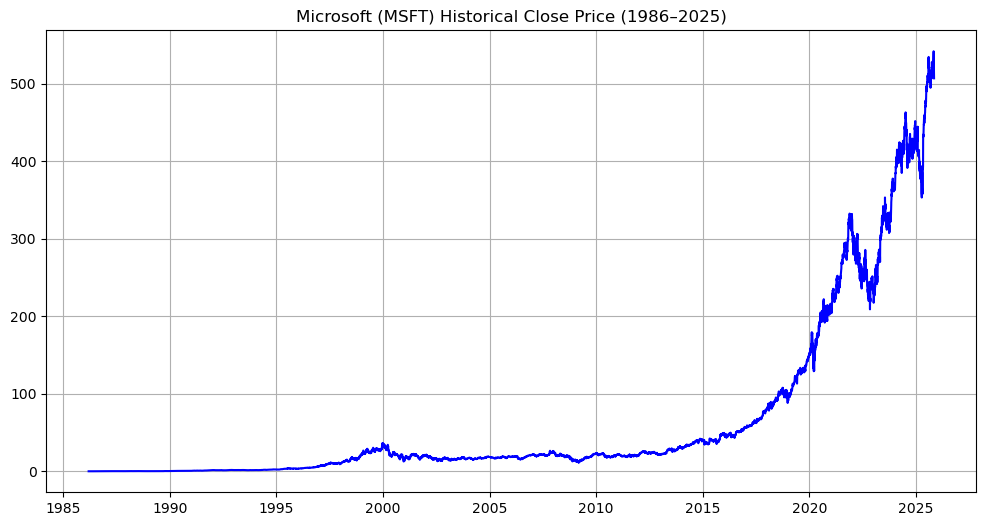

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], color='blue')
plt.title('Microsoft (MSFT) Historical Close Price (1986–2025)')
plt.grid(True)
plt.show()

In [47]:
import numpy as np
import datetime

#  Helper function 
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    """Convert time series into a windowed dataframe (for LSTM input)."""
    def str_to_datetime(s):
        return datetime.datetime.strptime(s, "%Y-%m-%d")

    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date
    dates, X, Y = [], [], []

    all_dates = dataframe.index.to_list()
    i = all_dates.index(target_date)

    while True:
        if i - n < 0:
            break
        window = dataframe.iloc[i - n:i + 1]['Close'].to_numpy()
        if len(window) != n + 1:
            break

        x = window[:-1]
        y = window[-1]
        dates.append(all_dates[i])
        X.append(x)
        Y.append(y)

        if all_dates[i] == last_date:
            break
        i += 1
        if i >= len(all_dates):
            break

    # Build new dataframe
    X = np.array(X)
    windowed_df = pd.DataFrame({'Target Date': dates})
    for j in range(n):
        windowed_df[f'Target-{n-j}'] = X[:, j]
    windowed_df['Target'] = Y

    return windowed_df

# Create windowed dataframe 
windowed_df = df_to_windowed_df(df, '2022-01-03', '2025-11-05', n=3)
print("\nWindowed DataFrame:")
print(windowed_df.head())
print(f"\nShape: {windowed_df.shape}")


Windowed DataFrame:
  Target Date    Target-3    Target-2    Target-1      Target
0  2022-01-03  331.484253  328.934784  326.026550  324.504608
1  2022-01-04  328.934784  326.026550  324.504608  318.940369
2  2022-01-05  326.026550  324.504608  318.940369  306.696838
3  2022-01-06  324.504608  318.940369  306.696838  304.273346
4  2022-01-07  318.940369  306.696838  304.273346  304.428436

Shape: (965, 5)


In [48]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:,0]

    middle_matrix = df_as_np[:,1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1],1))

    Y = df_as_np[:, -1]
    
    return dates , X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
print(dates.shape, X.shape, y.shape)

(965,) (965, 3, 1) (965,)


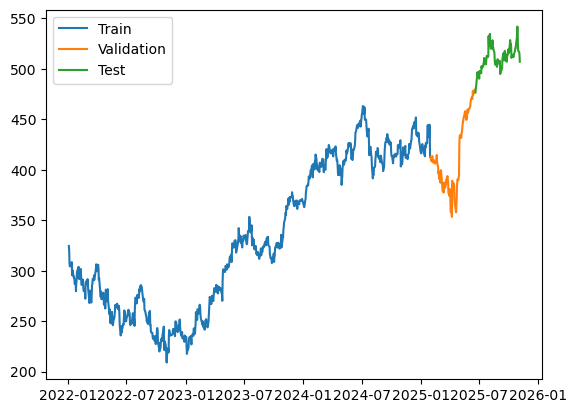

In [49]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train , X_train , y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val ,X_val ,y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test ,X_test ,y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train','Validation','Test'])

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, patience=5, verbose=1)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential([layers.Input((3,1)),
                    layers.LSTM(64, return_sequences=True),
                    layers.Dropout(0.2),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer = Adam(learning_rate=0.0005),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=200,
          callbacks=[early_stopping, lr_scheduler])

Epoch 1/200
25/25 [==============================] - 4s 41ms/step - loss: 114887.9922 - mean_absolute_error: 331.2304 - val_loss: 171375.5469 - val_mean_absolute_error: 412.4712 - lr: 5.0000e-04
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 114098.9844 - mean_absolute_error: 330.0354 - val_loss: 169635.4219 - val_mean_absolute_error: 410.3564 - lr: 5.0000e-04
Epoch 3/200
25/25 [==============================] - 0s 6ms/step - loss: 111809.0703 - mean_absolute_error: 326.5377 - val_loss: 165269.6250 - val_mean_absolute_error: 405.0014 - lr: 5.0000e-04
Epoch 4/200
25/25 [==============================] - 0s 5ms/step - loss: 107728.4844 - mean_absolute_error: 320.2343 - val_loss: 159969.1250 - val_mean_absolute_error: 398.4042 - lr: 5.0000e-04
Epoch 5/200
25/25 [==============================] - 0s 6ms/step - loss: 103818.0938 - mean_absolute_error: 314.0776 - val_loss: 155449.1250 - val_mean_absolute_error: 392.6908 - lr: 5.0000e-04
Epoch 6/200
25/25 [==========